In [1]:
# Install some dependencies
# !pip install -r requirements.txt

> **NOTE: Wait for the previous cell to complete, then restart the kernel before running the next cell. This ensures that the dependencies we have just installed will work. Otherwise you may receive an error when running imports in the next cell!**

# Transfer Learning

In many real-world situations you will not want to train a whole convolutional network from scratch, unless you happen to have a very large dataset and a lot of compute resources. Training a modern CNN on a dataset like ImageNet takes days or weeks on multiple GPUs. Instead, in most cases you will be using Transfer Learning.

<center><img src="notebook_ims/fine_tune_quadrants.png" width="80%"></center>

In this notebook, you'll be modeling a small dataset of fewer than 5000 natural images. As the diagram above suggests, in a case like this you can use the pre-trained network as a feature extractor and substitute the head. Since 5000 is small but not very small, you can also try to squeeze some more performance by fine-tuning the rest of the network. You will need to use a learning rate small enough so you do not destroy the filters that the network has learned on ImageNet.

In this exercise you will load a pre-trained ResNet model, remove the head, and substitute it with your own head. Then you will fix the feature extractor part and train the head. It is relatively easy to approach an accuracy of around 90% by using this transfer learning technique! Then you will fine-tune the rest of the network. Be careful in using a small learning rate! Experimentation usually is needed to find the right learning rate. Here we will use 1/100th of the initial learning rate. 

Let's start by importing a few modules and functions:

In [5]:
import torchvision.datasets
import torchvision.transforms as T
import torchvision.models
from torchvision.models import ResNet50_Weights
import torch.optim
from torch import nn
from helpers import *
import timm
from lr_finder import lr_finder
import glob
import matplotlib.pyplot as plt

Now let's create the data loaders. 

When the dataset is small it is difficult to split the dataset 3 ways (train, validation, and test) because you might not have enough data to train, validate, or test. Instead, you can use k-fold cross-validation: you divide the dataset in k parts, then you repeat the training k times, each time taking k-1 parts as your training dataset, and the remaining k-th part as your validation. You record your metrics for each iteration,  then you use the average performance as your metric.

However, to make things faster for this exercise, we will execute only one run of cross-validation among the k runs we should do in reality.

For simplicity we provide the code in the `helpers.py` file; feel free to look into it to see how the data is loaded. Note that the first time the code will compute the mean and std of the dataset, to be used in the `Normalize` transform in the data loaders (see the code in `helpers.py` for details):

In [2]:
data_loaders = get_data_loaders(batch_size=32, rand_augment_magnitude=15)

Reusing cached mean and std
Dataset mean: tensor([0.4589, 0.4200, 0.3004]), std: tensor([0.3005, 0.2702, 0.2941])
Reusing cached mean and std
n_tot: 4317
torch.Size([3453])


In [3]:
classes = ["daisy", "tulip", "dandelion", "sunflower", "rose"]

# Create the model and substitute the head
Let's now load a pretrained model and substitute its head. Let's use a `resnet50` from `torchvision` and substitute its head with a fully-connected layer (`Linear`) with the right input and output dimension:

In [6]:
# Load a resnet50 from torchvision
model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT) # YOUR CODE HERE. Remember to use pretrained=True

n_classes = len(classes)
n_inputs = model.fc.in_features

# Add a new linear layer in place of the existing one
# YOUR CODE HERE
model.fc = nn.Linear(n_inputs, n_classes)

We could have done the same by using TIMM:

In [6]:
# We can also use TIMM to get a pre-trained model
# model = timm.create_model("resnet18", pretrained=True, num_classes=n_classes)

## Freeze the backbone and thaw the head
Now we need to freeze all layers except the one we just added. Let's keep track of the parameters we are freezing so we will be able to free them later:

In [7]:
frozen_parameters = []

for p in model.parameters():
    # Freeze only parameters that are not already frozen
    # (if any)
    if p.requires_grad:
        # Freeze this parameter
        
        p.requires_grad = False # YOUR CODE HERE
        
        frozen_parameters.append(p)

print(f"Froze {len(frozen_parameters)} groups of parameters")

# Now let's thaw the parameters of the head we have
# added
for p in model.fc.parameters():
    # Thaw this parameter
    p.requires_grad = True# YOUR CODE HERE

Froze 161 groups of parameters


## Train
Now we can train our model. We start with the usual learning rate finder:

In [8]:
loss = nn.CrossEntropyLoss()

In [9]:
losses = lr_finder(1e-5, 0.1, 100, loss, model, data_loaders)

Learning rate finder:  92%|██████████████████▎ | 99/108 [00:13<00:01,  7.51it/s]


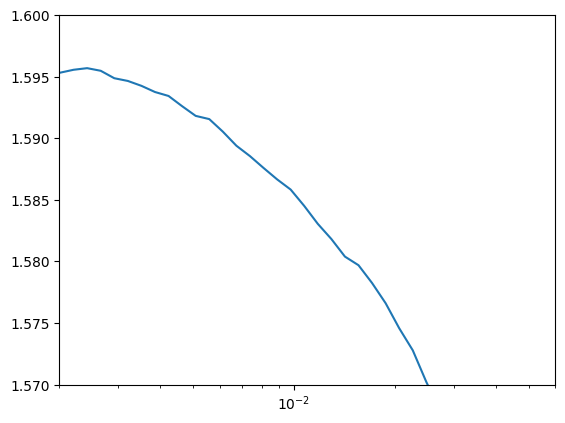

In [27]:
_ = plt.plot(losses.keys(), losses.values())
_ = plt.xscale("log")

# You might need to adjust this to cover the right
# portion of the y axis to better see the decrease
# in the loss before it shoots up again
_ = plt.ylim([1.57, 1.60])
_ = plt.xlim([2e-3, 6e-2])


Looks like a good learning rate is 0.005. Let's train first the head for a few epochs, to bring its weights (that right now are randomly initialized) to a place where they interact well with the feature extraction part:

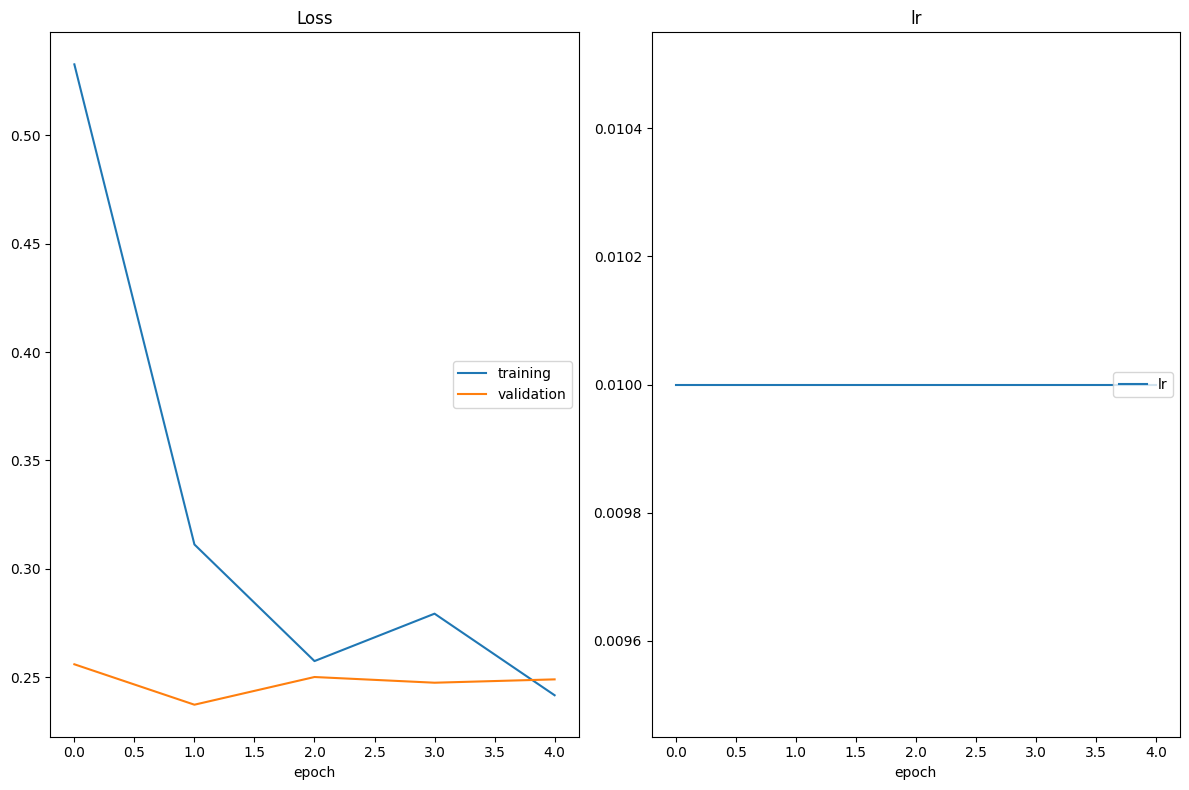

In [28]:
n_epochs = 5
# lr = 0.005
lr = 0.01

# Create an Adam optimizer that uses the learning rate in the
# variable lr
optimizer = torch.optim.Adam(model.parameters(), lr) # YOUR CODE HERE

optimize(
    data_loaders, 
    model, 
    optimizer, 
    loss, 
    n_epochs, 
    'initial.pt', 
    interactive_tracking=True
)

In [29]:
_ = one_epoch_test(data_loaders['valid'], model, loss)

Testing: 100%|██████████████████████████████████| 27/27 [00:07<00:00,  3.42it/s]

Test Loss: 0.248993


Test Accuracy: 92% (797/864)


Just by training the new head for a few epochs we reached already a very good performance. Now let's unfreeze the parameters we have frozen before:

In [30]:
# Thaw parameters we had frozen before
for p in frozen_parameters:
    p.requires_grad = True

and let's fine-tune the model. Remember to use a learning rate that is much smaller than what we used before. This is to avoid getting large steps, that would destroy the advantage of using a pre-trained network. For example, you might use a learning rate 100 times smaller than what we used before:

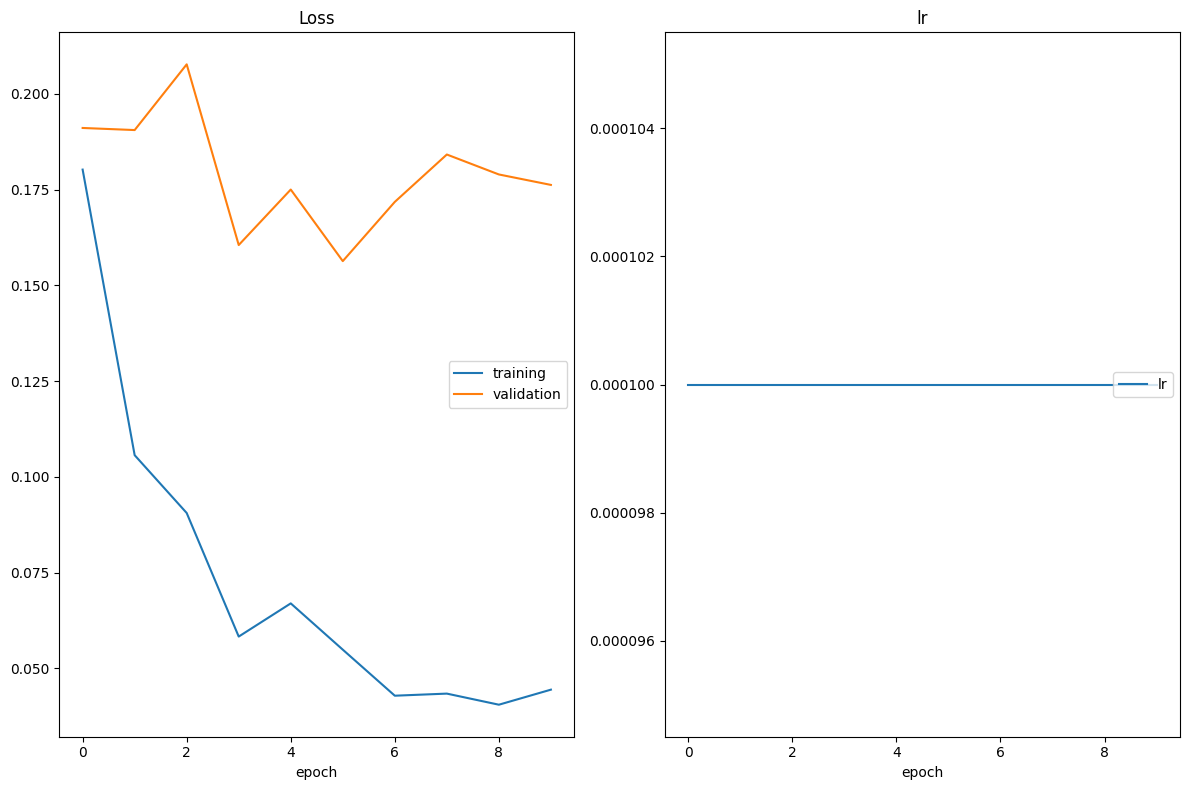

In [31]:
n_epochs = 10
lr = lr/100

optimizer = torch.optim.Adam(model.parameters(), lr)

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs,
    "best.pt",
    interactive_tracking=True,
)

In [32]:
_ = one_epoch_test(data_loaders['valid'], model, loss)

Testing: 100%|██████████████████████████████████| 27/27 [00:07<00:00,  3.40it/s]

Test Loss: 0.176228


Test Accuracy: 95% (828/864)


With fine-tuning we have significantly increased our performance to 95%! 

Now let's see what would happen if we train from scratch. 

The following code does just that. We have already executed it because it takes a long time. As you can see, despite training for 10x more epochs than when using transfer learning, our performance is significantly worse!

Can you explain why?

In [ ]:
# Let's train from scratch
model = torchvision.models.resnet50(pretrained=False)
n_classes = len(classes)
n_inputs = model.fc.in_features
model.fc = nn.Linear(n_inputs, n_classes)

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
losses = lr_finder(1e-5, 0.2, 100, loss, model, data_loaders)

In [ ]:
_ = plt.plot(losses.keys(), losses.values())
_ = plt.xscale("log")
_ = plt.ylim([1.63, 1.7])

In [ ]:
optimize(data_loaders, model, torch.optim.Adam(model.parameters(), 0.001), loss, 100, 'best_scratch.pt', interactive_tracking=True)

In [ ]:
_ = one_epoch_test(data_loaders['valid'], model, loss)